In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(1,'drive/MyDrive/final_assignment_xrays')
import Preprocessing as preprocess

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import tensorflow.python.keras as keras
import tensorflow.python.keras.layers as layers
import matplotlib.pyplot as plt
import math
import shutil
import cv2
import os 
import random
import glob 
#from tensorflow.python.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import classification_report

# Task 1: Load the chest x-ray dataset and Print some sample images.

In [ ]:
# Extract Directories from preprocess.py

data_dir = preprocess.data_dir
test_path = preprocess.test_path
train_path = preprocess.train_path
normal_path = preprocess.normal_path
pneumonia_path = preprocess.pneumonia_path

print(data_dir)

/content/drive/MyDrive/final_assignment_xrays/XRays


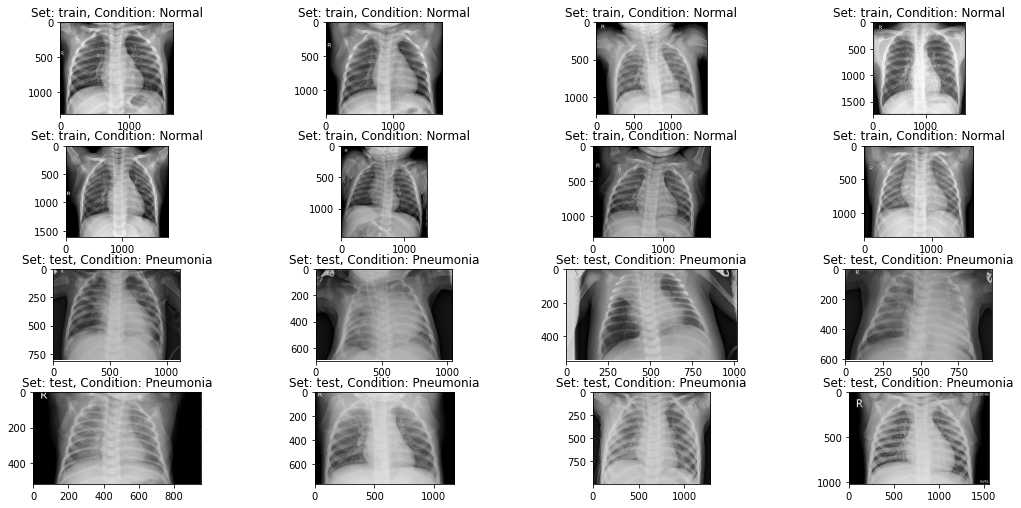

In [ ]:
# Print some Images

preprocess.ShowImages()

In [ ]:
# Initialise the Data Generator object, and get return some statistics about the data balance

preprocess.GenerateData.initialise()
class_weights = preprocess.CalculateDataStats()

Found 5232 images belonging to 2 classes.
Normal:1349
Pneumonia:3883
Imbalance Ratio: 2.88

Weighting classes by:
Normal:2.88
Pneumonia:1.00



In [ ]:
# Perform necessary tasks for K-fold cross validation

k = 10

preprocess.MakeDirectories(k)
preprocess.Create_KFold_TrainingData(k)
preprocess.Create_KFold_ValidationData(k)

# Task 2: Logistic Regression Model

In [ ]:
# Instantiate generator for training data, and define constants

data_train = preprocess.GenerateData.training_data_flow(train_path, "grayscale")
data_val = preprocess.GenerateData.validation_data_flow(train_path, "grayscale")

STEP_SIZE_TRAIN=data_train.n//data_train.batch_size
STEP_SIZE_VALID=data_val.n//data_val.batch_size
    
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
checkpoint = ModelCheckpoint((data_dir + '/checkpoints' + '/LogReg'), monitor='val_loss', 
                              verbose=0, save_best_only=True, save_weights_only=True)
callback_list = [checkpoint, early]

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
# Instantiate model
model = preprocess.LogReg()

print('\n')

# Execute fit method
history = model.fit(data_train,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = data_val,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list,
                    class_weight=class_weights)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 41474     
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 41,474
Trainable params: 41,474
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
147/147 [==============================] - 48s 322ms/step - loss: 0.8647 - accuracy: 0.7189 - val_loss: 0.3674 - val_accuracy: 0.8555
Epoch 2/100
147/147 [==============================] - 47s 324ms/step - loss: 0.4588 - accuracy: 0.8895 - val_loss: 0.3485 - val_accuracy: 0.8301
Epoch 3/100
147/147 [==============================] - 47s 322ms/step - loss: 0.3859 - a

In [ ]:
data_test = preprocess.GenerateData.test_data_flow(test_path, "grayscale")
STEP_SIZE_TEST=data_test.n//data_test.batch_size

# Load best performing weights
model.load_weights((data_dir + '/checkpoints' + '/LogReg'))

acc = model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)

Found 624 images belonging to 2 classes.
39/39 [==============================] - 5s 124ms/step - loss: 0.5801 - accuracy: 0.7708


In [ ]:
data_test.reset()
preds = model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)

39/39 [==============================] - 5s 124ms/step


In [ ]:
# Convert the binary predictions array to class labels

y_pred = np.argmax(preds, axis = 1)
y_true = data_test.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]

In [ ]:
print(classification_report(true_labels, predicted_labels, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.925     0.423     0.581       234
   PNEUMONIA      0.739     0.979     0.842       390

    accuracy                          0.771       624
   macro avg      0.832     0.701     0.711       624
weighted avg      0.809     0.771     0.744       624



Trying denoised images

In [ ]:
# Instantiate generator for training data, and define constants

data_train_denoised = preprocess.GenerateData.training_data_flow(train_path, "grayscale", True)
data_val_denoised = preprocess.GenerateData.validation_data_flow(train_path, "grayscale", True)

STEP_SIZE_TRAIN=data_train_denoised.n//data_train_denoised.batch_size
STEP_SIZE_VALID=data_val_denoised.n//data_val_denoised.batch_size
    
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
checkpoint = ModelCheckpoint((data_dir + '/checkpoints' + '/LogReg'), monitor='val_loss', 
                              verbose=0, save_best_only=True, save_weights_only=True)
callback_list = [checkpoint, early]

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
# Instantiate model
model = preprocess.LogReg()

print('\n')

# Execute fit method
history = model.fit(data_train_denoised,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = data_val_denoised,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list,
                    class_weight=class_weights)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 41474     
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 41,474
Trainable params: 41,474
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
147/147 [==============================] - 286s 2s/step - loss: 0.8457 - accuracy: 0.7082 - val_loss: 0.3375 - val_accuracy: 0.8887
Epoch 2/100
147/147 [==============================] - 282s 2s/step - loss: 0.4636 - accuracy: 0.8890 - val_loss: 0.3221 - val_accuracy: 0.8633
Epoch 3/100
147/147 [==============================] - 284s 2s/step - loss: 0.3745 - accur

In [ ]:
data_test_denoised = preprocess.GenerateData.test_data_flow(test_path, "grayscale", True)
STEP_SIZE_TEST=data_test_denoised.n//data_test_denoised.batch_size

# Load best performing weights
model.load_weights((data_dir + '/checkpoints' + '/LogReg'))

acc = model.evaluate(data_test_denoised, steps=STEP_SIZE_TEST, verbose= 1)

Found 624 images belonging to 2 classes.
39/39 [==============================] - 33s 852ms/step - loss: 0.5858 - accuracy: 0.7660


In [ ]:
data_test_denoised.reset()
preds = model.predict(data_test_denoised, steps=STEP_SIZE_TEST, verbose= 1)

39/39 [==============================] - 34s 857ms/step


In [ ]:
# Convert the binary predictions array to class labels

y_pred = np.argmax(preds, axis = 1)
y_true = data_test_denoised.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test_denoised.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]
print(classification_report(true_labels, predicted_labels, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.940     0.402     0.563       234
   PNEUMONIA      0.733     0.985     0.840       390

    accuracy                          0.766       624
   macro avg      0.836     0.693     0.702       624
weighted avg      0.811     0.766     0.736       624



In [ ]:
# Instantiate generator for training data, and define constants

data_train_denoised_ = preprocess.GenerateData.training_data_flow_augmented(train_path, "grayscale")
data_val_denoised_ = preprocess.GenerateData.validation_data_flow_augmented(train_path, "grayscale")

STEP_SIZE_TRAIN=data_train_denoised_.n//data_train_denoised_.batch_size
STEP_SIZE_VALID=data_val_denoised_.n//data_val_denoised_.batch_size
    
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
checkpoint = ModelCheckpoint((data_dir + '/checkpoints' + '/LogReg'), monitor='val_loss', 
                              verbose=0, save_best_only=True, save_weights_only=True)
callback_list = [checkpoint, early]

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
# Instantiate model
model = preprocess.LogReg()

print('\n')

# Execute fit method
history = model.fit(data_train_denoised_,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = data_val_denoised_,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list,
                    class_weight=class_weights)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 41474     
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 41,474
Trainable params: 41,474
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
147/147 [==============================] - 2277s 16s/step - loss: 0.8924 - accuracy: 0.6647 - val_loss: 0.5330 - val_accuracy: 0.7441
Epoch 2/100
147/147 [==============================] - 71s 482ms/step - loss: 0.5470 - accuracy: 0.8438 - val_loss: 0.3254 - val_accuracy: 0.8828
Epoch 3/100
147/147 [==============================] - 70s 479ms/step - loss: 0.4427 - a

In [ ]:
data_test_denoised_ = preprocess.GenerateData.test_data_flow_augmented(test_path, "grayscale")
STEP_SIZE_TEST=data_test_denoised_.n//data_test_denoised_.batch_size

# Load best performing weights
model.load_weights((data_dir + '/checkpoints' + '/LogReg'))

acc = model.evaluate(data_test_denoised_, steps=STEP_SIZE_TEST, verbose= 1)

Found 624 images belonging to 2 classes.
39/39 [==============================] - 257s 7s/step - loss: 0.4676 - accuracy: 0.7788


In [ ]:
data_test_denoised_.reset()
preds = model.predict(data_test_denoised_, steps=STEP_SIZE_TEST, verbose= 1)

39/39 [==============================] - 8s 197ms/step


In [ ]:
# Convert the binary predictions array to class labels

y_pred = np.argmax(preds, axis = 1)
y_true = data_test_denoised_.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test_denoised_.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]
print(classification_report(true_labels, predicted_labels, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.891     0.491     0.634       234
   PNEUMONIA      0.760     0.964     0.850       390

    accuracy                          0.787       624
   macro avg      0.826     0.728     0.742       624
weighted avg      0.809     0.787     0.769       624



In [ ]:
# Instantiate generator for training data, and define constants

data_train_denoised_ = preprocess.GenerateData.training_data_flow_augmented(train_path, "grayscale", True)
data_val_denoised_ = preprocess.GenerateData.validation_data_flow_augmented(train_path, "grayscale", True)

STEP_SIZE_TRAIN=data_train_denoised_.n//data_train_denoised_.batch_size
STEP_SIZE_VALID=data_val_denoised_.n//data_val_denoised_.batch_size
    
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
checkpoint = ModelCheckpoint((data_dir + '/checkpoints' + '/LogReg'), monitor='val_loss', 
                              verbose=0, save_best_only=True, save_weights_only=True)
callback_list = [checkpoint, early]

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
# Instantiate model
model = preprocess.LogReg()

print('\n')

# Execute fit method
history = model.fit(data_train_denoised_,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = data_val_denoised_,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list,
                    class_weight=class_weights)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 41474     
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 41,474
Trainable params: 41,474
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
147/147 [==============================] - 299s 2s/step - loss: 0.8463 - accuracy: 0.7154 - val_loss: 0.4026 - val_accuracy: 0.8574
Epoch 2/100
147/147 [==============================] - 297s 2s/step - loss: 0.5165 - accuracy: 0.8719 - val_loss: 0.3320 - val_accuracy: 0.8691
Epoch 3/100
147/147 [==============================] - 297s 2s/step - loss: 0.4489 - accur

In [ ]:
data_test_denoised_ = preprocess.GenerateData.test_data_flow_augmented(test_path, "grayscale", True)
STEP_SIZE_TEST=data_test_denoised_.n//data_test_denoised_.batch_size

# Load best performing weights
model.load_weights((data_dir + '/checkpoints' + '/LogReg'))

acc = model.evaluate(data_test_denoised_, steps=STEP_SIZE_TEST, verbose= 1)

Found 624 images belonging to 2 classes.
39/39 [==============================] - 35s 891ms/step - loss: 0.5198 - accuracy: 0.7564


In [ ]:
data_test_denoised_.reset()
preds = model.predict(data_test_denoised_, steps=STEP_SIZE_TEST, verbose= 1)

39/39 [==============================] - 35s 896ms/step


In [ ]:
# Convert the binary predictions array to class labels

y_pred = np.argmax(preds, axis = 1)
y_true = data_test_denoised_.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test_denoised_.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]
print(classification_report(true_labels, predicted_labels, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.871     0.432     0.577       234
   PNEUMONIA      0.738     0.962     0.835       390

    accuracy                          0.763       624
   macro avg      0.804     0.697     0.706       624
weighted avg      0.788     0.763     0.738       624



In [ ]:
# Cleanup
del model
keras.backend.clear_session    
data_train.reset()
data_val.reset()
data_test.reset()
data_train_denoised.reset()
data_val_denoised.reset()
data_test_denoised.reset()

# Task 3: Train a convolutional neural network model to recognise pneumonia

In [ ]:
# Execute a K-fold cross validation strategy

# Initialise constants
k = 10
predicted_labels_final = []
true_labels_final = []

# Main loop - 'for each fold'
for i in range(0,k):
    
    checkpoint = ModelCheckpoint((data_dir + '/fold' + str(i+1) + '/checkpoints'), monitor='val_loss', 
                                 verbose=0, save_best_only=True, save_weights_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    callback_list = [checkpoint, early]
    
    # Instantiate generator for training data, and define constants
    dir_ = (data_dir + '/fold' + str(i+1) + '/train')
    data_train = preprocess.GenerateData.data_flow(dir_, "grayscale")
    STEP_SIZE_TRAIN=data_train.n//data_train.batch_size
    
    # Instantiate generator for validation data, and define constants
    dir_ = (data_dir + '/fold' + str(i+1) + '/validate')
    data_val = preprocess.GenerateData.data_flow(dir_, "grayscale")
    STEP_SIZE_VALID=data_val.n//data_val.batch_size
    
    print('\n')
    
    # Instantiate model
    K_model = preprocess.LeNet5()
    
    print('\n')
        
    # Execute fit method
    history = K_model.fit(data_train,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = data_val,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list)
    
    print('\n')    
 
    # Load best performing weights
    K_model.load_weights((data_dir + '/fold' + str(i+1) + '/checkpoints'))
    
    # Instantiate generator for test data, and define constants
    data_test = preprocess.GenerateData.test_data_flow(test_path, "grayscale")
    STEP_SIZE_TEST=data_test.n//data_test.batch_size
    
    # Evaluate the performance of the model for early insight
    print('\n Evaluating Model')    
    acc = K_model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)
    
    # Generate some predictions
    print('\n Generating Predictions')
    data_test.reset()
    preds = K_model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)
    
    # Convert the binary predictions array to class labels, and append to final predictions
    y_pred = np.argmax(preds, axis = 1)
    y_true = data_test.classes
    
    predicted_class_indices = np.argmax(preds,axis=-1)
    labels = (data_test.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predicted_labels = [labels[k] for k in predicted_class_indices]
    true_labels = [labels[k] for k in y_true]
    
    predicted_labels_final.extend(predicted_labels)
    true_labels_final.extend(true_labels)
    
    # Cleanup
    del K_model
    keras.backend.clear_session    
    data_train.reset()
    data_val.reset()
    data_test.reset()

In [ ]:
predicted_labels_final = []
true_labels_final = []
checkpoint = ModelCheckpoint((data_dir + '/checkpoints'+'/LeNet5'), monitor='val_loss', 
                                 verbose=0, save_best_only=True, save_weights_only=True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

callback_list = [checkpoint, early]

# Instantiate generator for training data, and define constants
dir_ = (data_dir + '/train')
data_train = preprocess.GenerateData.training_data_flow(train_path, "grayscale")
STEP_SIZE_TRAIN=data_train.n//data_train.batch_size

# Instantiate generator for validation data, and define constants
dir_ = (data_dir + '/validate')
data_val = preprocess.GenerateData.validation_data_flow(train_path, "grayscale")
STEP_SIZE_VALID=data_val.n//data_val.batch_size

print('\n')

# Instantiate model
K_model = preprocess.LeNet5()

print('\n')
    
# Execute fit method
history = K_model.fit(data_train,
                steps_per_epoch = STEP_SIZE_TRAIN,
                validation_data = data_val,
                validation_steps = STEP_SIZE_VALID,
                epochs = 100,
                callbacks = callback_list,
                class_weight = class_weights)

print('\n')    

# Load best performing weights
K_model.load_weights((data_dir + '/checkpoints' + '/LeNet5'))

# Instantiate generator for test data, and define constants
data_test = preprocess.GenerateData.test_data_flow(test_path, "grayscale")
STEP_SIZE_TEST=data_test.n//data_test.batch_size

# Evaluate the performance of the model for early insight
print('\n Evaluating Model')    
acc = K_model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)

# Generate some predictions
print('\n Generating Predictions')
data_test.reset()
preds = K_model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)

# Convert the binary predictions array to class labels, and append to final predictions
y_pred = np.argmax(preds, axis = 1)
y_true = data_test.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]

predicted_labels_final.extend(predicted_labels)
true_labels_final.extend(true_labels)

# Cleanup
del K_model
keras.backend.clear_session    
data_train.reset()
data_val.reset()
data_test.reset()

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 124, 6)       156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 79, 62, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 58, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 37, 29, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 25, 120)       48120     
_________________________________________________________________
flatten_4 (Flatten)          (None, 99000)             0         
___________________________________

In [ ]:
print(classification_report(true_labels_final, predicted_labels_final, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.931     0.346     0.505       234
   PNEUMONIA      0.715     0.985     0.828       390

    accuracy                          0.745       624
   macro avg      0.823     0.665     0.667       624
weighted avg      0.796     0.745     0.707       624



Using denoise function

In [ ]:
# Execute a K-fold cross validation strategy

# Initialise constants
k = 10
predicted_labels_final = []
true_labels_final = []

# Main loop - 'for each fold'
for i in range(0,k):
    
    checkpoint = ModelCheckpoint((data_dir + '/fold' + str(i+1) + '/checkpoints'), monitor='val_loss', 
                                 verbose=0, save_best_only=True, save_weights_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    callback_list = [checkpoint, early]
    
    # Instantiate generator for training data, and define constants
    dir_ = (data_dir + '/fold' + str(i+1) + '/train')
    data_train = preprocess.GenerateData.data_flow(dir_, "grayscale", True)
    STEP_SIZE_TRAIN=data_train.n//data_train.batch_size
    
    # Instantiate generator for validation data, and define constants
    dir_ = (data_dir + '/fold' + str(i+1) + '/validate')
    data_val = preprocess.GenerateData.data_flow(dir_, "grayscale", True)
    STEP_SIZE_VALID=data_val.n//data_val.batch_size
    
    print('\n')
    
    # Instantiate model
    K_model = preprocess.LeNet5()
    
    print('\n')
        
    # Execute fit method
    history = K_model.fit(data_train,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = data_val,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list)
    
    print('\n')    
 
    # Load best performing weights
    K_model.load_weights((data_dir + '/fold' + str(i+1) + '/checkpoints'))
    
    # Instantiate generator for test data, and define constants
    data_test = preprocess.GenerateData.test_data_flow(test_path, "grayscale")
    STEP_SIZE_TEST=data_test.n//data_test.batch_size
    
    # Evaluate the performance of the model for early insight
    print('\n Evaluating Model')    
    acc = K_model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)
    
    # Generate some predictions
    print('\n Generating Predictions')
    data_test.reset()
    preds = K_model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)
    
    # Convert the binary predictions array to class labels, and append to final predictions
    y_pred = np.argmax(preds, axis = 1)
    y_true = data_test.classes
    
    predicted_class_indices = np.argmax(preds,axis=-1)
    labels = (data_test.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predicted_labels = [labels[k] for k in predicted_class_indices]
    true_labels = [labels[k] for k in y_true]
    
    predicted_labels_final.extend(predicted_labels)
    true_labels_final.extend(true_labels)
    
    # Cleanup
    del K_model
    keras.backend.clear_session    
    data_train.reset()
    data_val.reset()
    data_test.reset()

In [ ]:
print(classification_report(true_labels_final, predicted_labels_final, digits=3))

In [ ]:
predicted_labels_final = []
true_labels_final = []
checkpoint = ModelCheckpoint((data_dir + '/checkpoints'+'/LeNet5'), monitor='val_loss', 
                                 verbose=0, save_best_only=True, save_weights_only=True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

callback_list = [checkpoint, early]

# Instantiate generator for training data, and define constants
dir_ = (data_dir + '/train')
data_train = preprocess.GenerateData.training_data_flow(train_path, "grayscale", True)
STEP_SIZE_TRAIN=data_train.n//data_train.batch_size

# Instantiate generator for validation data, and define constants
dir_ = (data_dir + '/validate')
data_val = preprocess.GenerateData.validation_data_flow(train_path, "grayscale", True)
STEP_SIZE_VALID=data_val.n//data_val.batch_size

print('\n')

# Instantiate model
K_model = preprocess.LeNet5()

print('\n')
    
# Execute fit method
history = K_model.fit(data_train,
                steps_per_epoch = STEP_SIZE_TRAIN,
                validation_data = data_val,
                validation_steps = STEP_SIZE_VALID,
                epochs = 100,
                callbacks = callback_list,
                class_weight=class_weights)

print('\n')    

# Load best performing weights
K_model.load_weights((data_dir + '/checkpoints' + '/LeNet5'))

# Instantiate generator for test data, and define constants
data_test = preprocess.GenerateData.test_data_flow(test_path, "grayscale", True)
STEP_SIZE_TEST=data_test.n//data_test.batch_size

# Evaluate the performance of the model for early insight
print('\n Evaluating Model')    
acc = K_model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)

# Generate some predictions
print('\n Generating Predictions')
data_test.reset()
preds = K_model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)

# Convert the binary predictions array to class labels, and append to final predictions
y_pred = np.argmax(preds, axis = 1)
y_true = data_test.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]

predicted_labels_final.extend(predicted_labels)
true_labels_final.extend(true_labels)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 124, 6)       156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 79, 62, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 58, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 37, 29, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 25, 120)       48120     
_________________________________________________________________
flatten (Flatten)            (None, 99000)             0         
_____________________________________

In [ ]:
print(classification_report(true_labels_final, predicted_labels_final, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.944     0.359     0.520       234
   PNEUMONIA      0.720     0.987     0.832       390

    accuracy                          0.752       624
   macro avg      0.832     0.673     0.676       624
weighted avg      0.804     0.752     0.715       624



# Task 4 Use data augmentation techniques

In [ ]:
# Execute a K-fold cross validation strategy

# Initialise constants
k = 10
predicted_labels_final = []
true_labels_final = []

# Main loop - 'for each fold'
for i in range(0,k):
    
    checkpoint = ModelCheckpoint((data_dir + '/fold' + str(i+1) + '/checkpoints' + '/augmented'), monitor='val_loss', 
                                 verbose=0, save_best_only=True, save_weights_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

    callback_list = [checkpoint, early]
    
    # Instantiate generator for training data, and define constants
    dir_ = (data_dir + '/fold' + str(i+1) + '/train')
    data_train_augmented = preprocess.GenerateData.data_flow_augmented(dir_, "grayscale")
    STEP_SIZE_TRAIN=data_train.n//data_train.batch_size
    
    # Instantiate generator for validation data, and define constants
    dir_ = (data_dir + '/fold' + str(i+1) + '/validate')
    data_val_augmented = preprocess.GenerateData.data_flow_augmented(dir_, "grayscale")
    STEP_SIZE_VALID=data_val.n//data_val.batch_size
    
    print('\n')
    
    # Instantiate model
    K_model = preprocess.LeNet5()
    
    print('\n')
    
    # Execute fit method
    history = K_model.fit(data_train_augmented,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = data_val_augmented,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list)
    
    print('\n')    
    
    # Load best performing weights
    K_model.load_weights((data_dir + '/fold' + str(i+1) + '/checkpoints' + '/augmented'))
    
    # Instantiate generator for test data, and define constants
    data_test = preprocess.GenerateData.test_data_flow(test_path, "grayscale")
    STEP_SIZE_TEST=data_test.n//data_test.batch_size
    
    # Evaluate the performance of the model for early insight
    print('\n Evaluating Model')    
    acc = K_model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)
    
    # Generate some predictions
    print('\n Generating Predictions')
    data_test.reset()
    preds = K_model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)
    
    # Convert the binary predictions array to class labels, and append to final predictions
    y_pred = np.argmax(preds, axis = 1)
    y_true = data_test.classes
    
    predicted_class_indices = np.argmax(preds,axis=-1)
    labels = (data_test.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predicted_labels = [labels[k] for k in predicted_class_indices]
    true_labels = [labels[k] for k in y_true]
    
    predicted_labels_final.extend(predicted_labels)
    true_labels_final.extend(true_labels)
    
    # Cleanup
    del K_model
    keras.backend.clear_session    
    data_train_augmented.reset()
    data_val_augmented.reset()
    data_test.reset()

In [ ]:
print(classification_report(true_labels_final, predicted_labels_final, digits=3))

In [ ]:
predicted_labels_final = []
true_labels_final = []
checkpoint = ModelCheckpoint((data_dir + '/checkpoints'+'/LeNet5'), monitor='val_loss', 
                                 verbose=0, save_best_only=True, save_weights_only=True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

callback_list = [checkpoint, early]

# Instantiate generator for training data, and define constants
dir_ = (data_dir + '/train')
data_train = preprocess.GenerateData.training_data_flow_augmented(train_path, "grayscale")
STEP_SIZE_TRAIN=data_train.n//data_train.batch_size

# Instantiate generator for validation data, and define constants
dir_ = (data_dir + '/validate')
data_val = preprocess.GenerateData.validation_data_flow_augmented(train_path, "grayscale")
STEP_SIZE_VALID=data_val.n//data_val.batch_size

print('\n')

# Instantiate model
K_model = preprocess.LeNet5()

print('\n')
    
# Execute fit method
history = K_model.fit(data_train,
                steps_per_epoch = STEP_SIZE_TRAIN,
                validation_data = data_val,
                validation_steps = STEP_SIZE_VALID,
                epochs = 100,
                callbacks = callback_list,
                class_weight=class_weights)

print('\n')    

# Load best performing weights
K_model.load_weights((data_dir + '/checkpoints' + '/LeNet5'))

# Instantiate generator for test data, and define constants
data_test = preprocess.GenerateData.test_data_flow_augmented(test_path, "grayscale")
STEP_SIZE_TEST=data_test.n//data_test.batch_size

# Evaluate the performance of the model for early insight
print('\n Evaluating Model')    
acc = K_model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)

# Generate some predictions
print('\n Generating Predictions')
data_test.reset()
preds = K_model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)

# Convert the binary predictions array to class labels, and append to final predictions
y_pred = np.argmax(preds, axis = 1)
y_true = data_test.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]

predicted_labels_final.extend(predicted_labels)
true_labels_final.extend(true_labels)

# Cleanup
'''
del K_model
keras.backend.clear_session    
data_train.reset()
data_val.reset()
data_test.reset()
'''

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 158, 124, 6)       156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 79, 62, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 58, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 37, 29, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 25, 120)       48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 99000)             0         
___________________________________

'\ndel K_model\nkeras.backend.clear_session    \ndata_train.reset()\ndata_val.reset()\ndata_test.reset()\n'

In [ ]:
print(classification_report(true_labels_final, predicted_labels_final, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.967     0.376     0.542       234
   PNEUMONIA      0.726     0.992     0.839       390

    accuracy                          0.761       624
   macro avg      0.847     0.684     0.690       624
weighted avg      0.816     0.761     0.727       624



In [ ]:
predicted_labels_final = []
true_labels_final = []
checkpoint = ModelCheckpoint((data_dir + '/checkpoints'+'/LeNet5'), monitor='val_loss', 
                                 verbose=0, save_best_only=True, save_weights_only=True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

callback_list = [checkpoint, early]

# Instantiate generator for training data, and define constants
dir_ = (data_dir + '/train')
data_train = preprocess.GenerateData.training_data_flow_augmented(train_path, "grayscale", True)
STEP_SIZE_TRAIN=data_train.n//data_train.batch_size

# Instantiate generator for validation data, and define constants
dir_ = (data_dir + '/validate')
data_val = preprocess.GenerateData.validation_data_flow_augmented(train_path, "grayscale",True)
STEP_SIZE_VALID=data_val.n//data_val.batch_size

print('\n')

# Instantiate model
K_model = preprocess.LeNet5()

print('\n')
    
# Execute fit method
history = K_model.fit(data_train,
                steps_per_epoch = STEP_SIZE_TRAIN,
                validation_data = data_val,
                validation_steps = STEP_SIZE_VALID,
                epochs = 100,
                callbacks = callback_list,
                class_weight=class_weights)

print('\n')    

# Load best performing weights
K_model.load_weights((data_dir + '/checkpoints' + '/LeNet5'))

# Instantiate generator for test data, and define constants
data_test = preprocess.GenerateData.test_data_flow_augmented(test_path, "grayscale",True)
STEP_SIZE_TEST=data_test.n//data_test.batch_size

# Evaluate the performance of the model for early insight
print('\n Evaluating Model')    
acc = K_model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)

# Generate some predictions
print('\n Generating Predictions')
data_test.reset()
preds = K_model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)

# Convert the binary predictions array to class labels, and append to final predictions
y_pred = np.argmax(preds, axis = 1)
y_true = data_test.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]

predicted_labels_final.extend(predicted_labels)
true_labels_final.extend(true_labels)

# Cleanup
del K_model
keras.backend.clear_session    
data_train.reset()
data_val.reset()
data_test.reset()

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 124, 6)       156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 79, 62, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 58, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 37, 29, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 25, 120)       48120     
_________________________________________________________________
flatten (Flatten)            (None, 99000)             0         
_____________________________________

In [ ]:
print(classification_report(true_labels_final, predicted_labels_final, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.958     0.487     0.646       234
   PNEUMONIA      0.762     0.987     0.860       390

    accuracy                          0.800       624
   macro avg      0.860     0.737     0.753       624
weighted avg      0.836     0.800     0.780       624



# Task 5: pre-trained VGG16 model

In [ ]:
data_train = preprocess.GenerateData.training_data_flow(train_path, "rgb")
data_val = preprocess.GenerateData.validation_data_flow(train_path, "rgb")

STEP_SIZE_TRAIN=data_train.n//data_train.batch_size
STEP_SIZE_VALID=data_val.n//data_val.batch_size

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
model = preprocess.VGG_16(False)
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint((data_dir + '/checkpoints' + '/VGG16'), monitor='val_loss', 
                              verbose=0, save_best_only=True, save_weights_only=True)
callback_list = [checkpoint, early]

history = model.fit(data_train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=data_val,
                    validation_steps=STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list,
                    class_weight=class_weights)

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 162, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
______________________________________________________________

In [ ]:
data_test = preprocess.GenerateData.test_data_flow(test_path, "rgb")
STEP_SIZE_TEST=data_test.n//data_test.batch_size

model.load_weights((data_dir + '/checkpoints' + '/VGG16'))

acc = model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)

Found 624 images belonging to 2 classes.
39/39 [==============================] - 6s 137ms/step - loss: 0.8078 - accuracy: 0.7580


In [ ]:
data_test.reset()
preds = model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)

39/39 [==============================] - 6s 148ms/step


In [ ]:
y_pred = np.argmax(preds, axis = 1)
y_true = data_test.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]
print(classification_report(true_labels, predicted_labels, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.988     0.359     0.527       234
   PNEUMONIA      0.722     0.997     0.837       390

    accuracy                          0.758       624
   macro avg      0.855     0.678     0.682       624
weighted avg      0.822     0.758     0.721       624



In [ ]:
# Cleanup
del model
keras.backend.clear_session    
data_train_augmented.reset()
data_val_augmented.reset()
data_test.reset()

# With augmented

In [ ]:
data_train_augmented = preprocess.GenerateData.training_data_flow_augmented(train_path, "rgb")
data_val_augmented = preprocess.GenerateData.validation_data_flow_augmented(train_path, "rgb")

STEP_SIZE_TRAIN=data_train_augmented.n//data_train_augmented.batch_size
STEP_SIZE_VALID=data_val_augmented.n//data_val_augmented.batch_size

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
model = preprocess.VGG_16(False)
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint((data_dir + '/checkpoints' + '/VGG16'), monitor='val_loss', 
                              verbose=0, save_best_only=True, save_weights_only=True)
callback_list = [checkpoint, early]

history = model.fit(data_train_augmented,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=data_val_augmented,
                    validation_steps=STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list,
                    class_weight=class_weights)

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 162, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
______________________________________________________________

In [ ]:
data_test = preprocess.GenerateData.test_data_flow_augmented(test_path, "rgb")
STEP_SIZE_TEST=data_test.n//data_test.batch_size

model.load_weights((data_dir + '/checkpoints' + '/VGG16'))

acc = model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)

Found 624 images belonging to 2 classes.
39/39 [==============================] - 207s 5s/step - loss: 0.7162 - accuracy: 0.7324


In [ ]:
data_test.reset()
preds = model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)

39/39 [==============================] - 9s 234ms/step


In [ ]:
y_pred = np.argmax(preds, axis = 1)
y_true = data_test.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]
print(classification_report(true_labels, predicted_labels, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.987     0.316     0.479       234
   PNEUMONIA      0.709     0.997     0.829       390

    accuracy                          0.742       624
   macro avg      0.848     0.657     0.654       624
weighted avg      0.813     0.742     0.697       624



In [ ]:
# Cleanup
del model
keras.backend.clear_session    
data_train_augmented.reset()
data_val_augmented.reset()
data_test.reset()

# With denoise

In [ ]:
data_train = preprocess.GenerateData.training_data_flow(train_path, "rgb",True)
data_val = preprocess.GenerateData.validation_data_flow(train_path, "rgb",True)

STEP_SIZE_TRAIN=data_train.n//data_train.batch_size
STEP_SIZE_VALID=data_val.n//data_val.batch_size

True
False
rgb
Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
model = preprocess.VGG_16(False)
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint((data_dir + '/checkpoints' + '/VGG16'), monitor='val_loss', 
                              verbose=0, save_best_only=True, save_weights_only=True)
callback_list = [checkpoint, early]

history = model.fit(data_train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=data_val,
                    validation_steps=STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list,
                    class_weight=class_weights)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 162, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0   

In [ ]:
data_test = preprocess.GenerateData.test_data_flow(test_path, "rgb", True)
STEP_SIZE_TEST=data_test.n//data_test.batch_size

model.load_weights((data_dir + '/checkpoints' + '/VGG16'))

acc = model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)

Found 624 images belonging to 2 classes.
39/39 [==============================] - 59s 2s/step - loss: 0.7639 - accuracy: 0.7853


In [ ]:
data_test.reset()
preds = model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)

39/39 [==============================] - 59s 2s/step


In [ ]:
y_pred = np.argmax(preds, axis = 1)
y_true = data_test.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]
print(classification_report(true_labels, predicted_labels, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.990     0.432     0.601       234
   PNEUMONIA      0.745     0.997     0.853       390

    accuracy                          0.785       624
   macro avg      0.868     0.715     0.727       624
weighted avg      0.837     0.785     0.759       624



In [ ]:
# Cleanup
del model
keras.backend.clear_session    
data_train.reset()
data_val.reset()
data_test.reset()

with denoise and augmented

In [ ]:
data_train_augmented = preprocess.GenerateData.training_data_flow_augmented(train_path, "rgb",True)
data_val_augmented = preprocess.GenerateData.validation_data_flow_augmented(train_path, "rgb",True)

STEP_SIZE_TRAIN=data_train_augmented.n//data_train_augmented.batch_size
STEP_SIZE_VALID=data_val_augmented.n//data_val_augmented.batch_size

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
model = preprocess.VGG_16(False)
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint((data_dir + '/checkpoints' + '/VGG16'), monitor='val_loss', 
                              verbose=0, save_best_only=True, save_weights_only=True)
callback_list = [checkpoint, early]

history = model.fit(data_train_augmented,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=data_val_augmented,
                    validation_steps=STEP_SIZE_VALID,
                    epochs = 100,
                    callbacks = callback_list,
                    class_weight=class_weights)

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 162, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
______________________________________________________________

In [ ]:
data_test = preprocess.GenerateData.test_data_flow_augmented(test_path, "rgb",True)
STEP_SIZE_TEST=data_test.n//data_test.batch_size

model.load_weights((data_dir + '/checkpoints' + '/VGG16'))

acc = model.evaluate(data_test, steps=STEP_SIZE_TEST, verbose= 1)

Found 624 images belonging to 2 classes.
39/39 [==============================] - 316s 8s/step - loss: 0.5290 - accuracy: 0.7997


In [ ]:
data_test.reset()
preds = model.predict(data_test, steps=STEP_SIZE_TEST, verbose= 1)

39/39 [==============================] - 64s 2s/step


In [ ]:
y_pred = np.argmax(preds, axis = 1)
y_true = data_test.classes

predicted_class_indices = np.argmax(preds,axis=-1)
labels = (data_test.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in y_true]
print(classification_report(true_labels, predicted_labels, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.992     0.500     0.665       234
   PNEUMONIA      0.769     0.997     0.868       390

    accuracy                          0.811       624
   macro avg      0.880     0.749     0.767       624
weighted avg      0.852     0.811     0.792       624

